In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random seed for reproducibility
RANDOM_STATE = 42

In [3]:
# 1. Loading the Dataset
print("Loading dataset...")
df = pd.read_csv("Duolingo_data_03_07_final_standardized.csv")
pd.set_option('display.max_columns', None)
df

Loading dataset...


,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,average_blocks_per_session,average_blocks_per_day,average_sessions_per_day,session_length_variance,blocks_per_session_variance,blocks_per_day_variance,sessions_per_day_variance,response_time_variance,churn_time,churn_time_category
0,+4kwmfjD,0.227673,0.133858,0.378947,0.375000,0.002246,0.031466,0.003641,0.008832,0.610942,0.508028,0.514156,0.444444,0.755147,0.789055,0.000000,0.000000,0.163987,0.0,1
1,+IUzKF2l,0.332900,0.212815,0.500000,0.607595,0.002769,0.033279,0.003321,0.011009,0.646135,0.177752,0.045300,0.000000,0.329076,0.356443,0.441670,0.000000,0.237942,22.0,3
2,+Xv/6Nop,0.229710,0.140162,0.375000,0.397849,0.005831,0.044804,0.004645,0.015200,0.606883,0.300131,0.130238,0.133333,0.539885,0.622328,0.744112,0.225838,0.784566,5.0,1
3,+mMyHsNU,0.239135,0.000000,0.250307,0.225892,0.004481,0.000000,0.001964,0.008600,0.613978,0.322248,0.283126,0.355556,0.775884,0.715246,0.800309,0.458726,0.536977,6.0,1
4,+ziSnwWC,0.169845,0.065789,0.266409,0.328947,0.005608,0.024309,0.006240,0.010858,0.590596,0.069626,0.036523,0.166667,0.320580,0.380484,0.539567,0.252993,0.495177,13.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,y6797eWc,0.076945,0.015957,0.202454,0.090909,0.002950,0.014475,0.005458,0.009800,0.545205,0.123050,0.107305,0.333333,0.280746,0.191319,0.583260,0.376852,0.700965,3.0,1
308,yka558y8,0.144504,0.103175,0.166065,0.175000,0.021478,0.014423,0.010699,0.063518,0.559939,0.176606,0.133635,0.277778,0.522893,0.604499,0.863963,0.584944,0.897106,4.0,1
309,z/C43yrd,0.069785,0.044248,0.175258,0.088889,0.004046,0.030523,0.008156,0.009240,0.536617,0.075279,0.049183,0.222222,0.377410,0.472344,0.635845,0.376852,0.434084,6.0,1
310,z9FlLLzt,0.122254,0.000000,0.104911,0.105263,0.006673,0.000000,0.003753,0.007835,0.545946,0.159404,0.120895,0.277778,0.410431,0.406270,0.520763,0.085736,0.356913,3.0,1


In [4]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nDataset info:")
print(df.info())

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nSummary statistics:")
print(df.describe())

Dataset shape: (312, 20)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   user_id                                  312 non-null    object 
 1   block_average_correctness                312 non-null    float64
 2   reverse_tap_average_correctness          312 non-null    float64
 3   reverse_translate_average_correctness    312 non-null    float64
 4   listen_average_correctness               312 non-null    float64
 5   block_average_response_time              312 non-null    float64
 6   reverse_tap_average_response_time        312 non-null    float64
 7   reverse_translate_average_response_time  312 non-null    float64
 8   listen_average_response_time             312 non-null    float64
 9   user_ability_score                       312 non-null    float64
 10  average_bl

In [5]:
# 2. Data Preprocessing
print("\nChecking for missing values:")
print(df.isnull().sum())

# Convert churn_time_category to categorical target (binary classification)
# Let's consider categories 3 and 4 as "will churn" (1) and categories 1 and 2 as "will not churn" (0)
# df['will_churn'] = df['churn_time_category'].apply(lambda x: 1 if x >= 3 else 0)

print("\nTarget distribution:")
print(df['churn_time_category'].value_counts())
# print(df['1'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))


Checking for missing values:
user_id                                    0
block_average_correctness                  0
reverse_tap_average_correctness            0
reverse_translate_average_correctness      0
listen_average_correctness                 0
block_average_response_time                0
reverse_tap_average_response_time          0
reverse_translate_average_response_time    0
listen_average_response_time               0
user_ability_score                         0
average_blocks_per_session                 0
average_blocks_per_day                     0
average_sessions_per_day                   0
session_length_variance                    0
blocks_per_session_variance                0
blocks_per_day_variance                    0
sessions_per_day_variance                  0
response_time_variance                     0
churn_time                                 0
churn_time_category                        0
dtype: int64

Target distribution:
churn_time_category
1    142
2    1

In [6]:
# 3. Feature Selection
# Exclude the original target, churn_time (which would cause data leakage), and any other columns we don't want as features
features = [col for col in df.columns if col not in ['churn_time_category', 'user_id', 'churn_time']]
X = df[features]
y = df['churn_time_category']

print("\nSelected features:", features)


Selected features: ['block_average_correctness', 'reverse_tap_average_correctness', 'reverse_translate_average_correctness', 'listen_average_correctness', 'block_average_response_time', 'reverse_tap_average_response_time', 'reverse_translate_average_response_time', 'listen_average_response_time', 'user_ability_score', 'average_blocks_per_session', 'average_blocks_per_day', 'average_sessions_per_day', 'session_length_variance', 'blocks_per_session_variance', 'blocks_per_day_variance', 'sessions_per_day_variance', 'response_time_variance']


In [7]:
# 4. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 249
Testing samples: 63


In [8]:
# due to imbalanced dataset, use stratified train-test split
# X contains your features, y contains your target variable (churn_time_category)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,                 # 20% of data for testing
    random_state=RANDOM_STATE,     # For reproducibility
    stratify=y                     # This is the key parameter for stratified sampling
)

In [9]:
# Verify
# Before splitting
print("Original class distribution:")
print(y.value_counts(normalize=True))

# After splitting
print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))

Original class distribution:
churn_time_category
1    0.455128
2    0.362179
3    0.182692
Name: proportion, dtype: float64

Training set class distribution:
churn_time_category
1    0.453815
2    0.361446
3    0.184739
Name: proportion, dtype: float64

Testing set class distribution:
churn_time_category
1    0.460317
2    0.365079
3    0.174603
Name: proportion, dtype: float64


## Train basic model

In [11]:
# Create DMatrix for faster processing
y_train_zero = y_train - 1
y_test_zero = y_test - 1
dtrain = xgb.DMatrix(X_train, label=y_train_zero)
dtest = xgb.DMatrix(X_test, label=y_test_zero)

# Define parameters
params = {
    'objective': 'multi:softmax',  # multiclass classification
    'num_class': 3,                # 4 classes (1, 2, 3)
    'eta': 0.1,                    # learning rate
    'max_depth': 6,                # max depth of trees
    'subsample': 0.8,              # subsample ratio
    'colsample_bytree': 0.8,       # feature subsample ratio
    'min_child_weight': 1,         # min sum of instance weight needed in a child
    'eval_metric': 'mlogloss',     # evaluation metric for multiclass
    'seed': RANDOM_STATE,          # for reproducibility
    'tree_method': 'hist'          # faster tree construction algorithm
}

# Train the model
print("\nTraining a basic XGBoost model...")
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)


Training a basic XGBoost model...


In [13]:
# Calculate training accuracy
y_train_pred = xgb_model.predict(dtrain)
train_accuracy = accuracy_score(y_train_zero, y_train_pred)
print(f"Training accuracy: {train_accuracy:.4f}")

Training accuracy: 1.0000


In [14]:
# Evaluate the basic model
y_pred = xgb_model.predict(dtest)
accuracy = accuracy_score(y_test_zero, y_pred)
print(f"\nBasic XGBoost model accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_zero, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_zero, y_pred)
print(cm)


Basic XGBoost model accuracy: 0.4762

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        29
           1       0.38      0.39      0.38        23
           2       0.10      0.09      0.10        11

    accuracy                           0.48        63
   macro avg       0.39      0.39      0.39        63
weighted avg       0.47      0.48      0.47        63


Confusion Matrix:
[[20  5  4]
 [ 9  9  5]
 [ 0 10  1]]


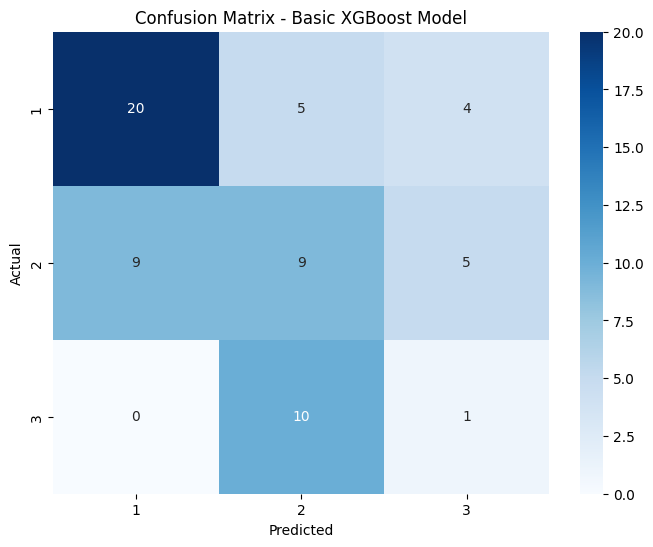

In [15]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3'],
            yticklabels=['1', '2', '3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Basic XGBoost Model')
plt.show()


Feature Importance (Gain):
                                    Feature  Importance
10                   average_blocks_per_day    1.104750
11                 average_sessions_per_day    0.956824
14                  blocks_per_day_variance    0.788886
5         reverse_tap_average_response_time    0.685124
15                sessions_per_day_variance    0.624337
13              blocks_per_session_variance    0.615407
4               block_average_response_time    0.611553
16                   response_time_variance    0.540931
1           reverse_tap_average_correctness    0.520420
12                  session_length_variance    0.510433
7              listen_average_response_time    0.498227
6   reverse_translate_average_response_time    0.491838
8                        user_ability_score    0.489798
9                average_blocks_per_session    0.472776
3                listen_average_correctness    0.470306
0                 block_average_correctness    0.463419
2     reverse_transl

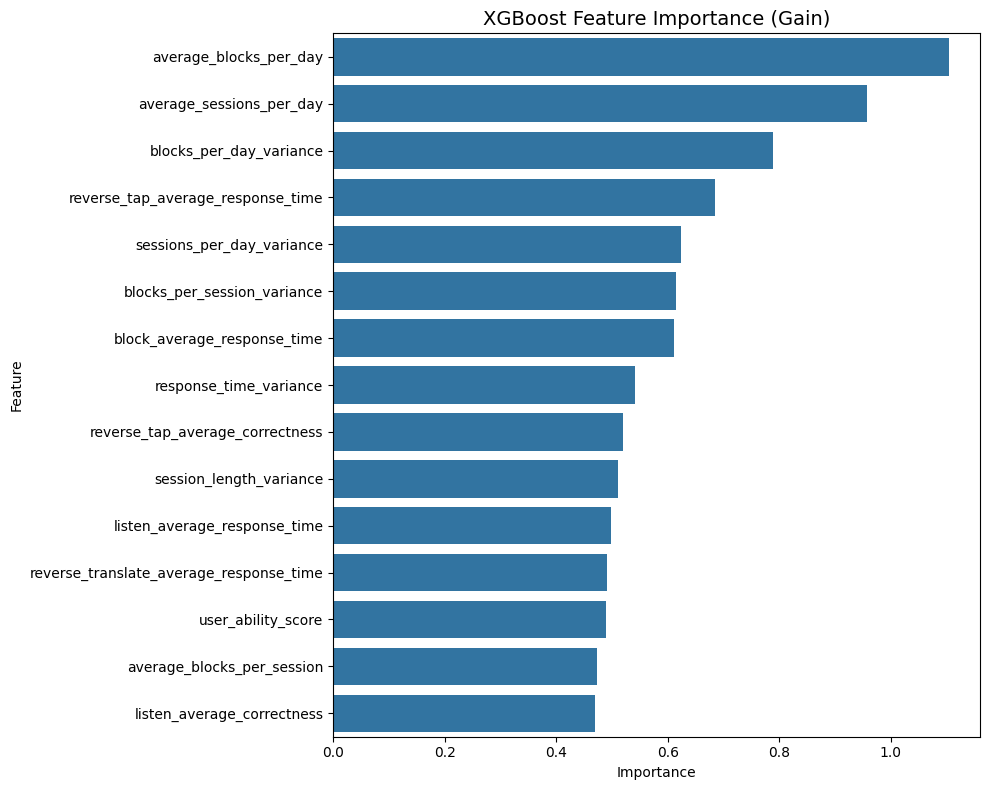

In [16]:
# XGBoost provides multiple importance measures - use 'gain'
importance_gain = xgb_model.get_score(importance_type='gain')

# Create dataframe for visualization
feature_importance = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance': list(importance_gain.values())
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nFeature Importance (Gain):")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance[:15])  # Show top 15 features
plt.title('XGBoost Feature Importance (Gain)', fontsize=14)
plt.tight_layout()
plt.show()

## CV tuning

In [18]:
# Use sklearn's XGBClassifier for easier integration with GridSearchCV
print("\nPerforming hyperparameter tuning...")

# Create XGBClassifier
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=RANDOM_STATE,
    tree_method='hist',
    eval_metric='mlogloss'
)

# Setup CV with stratification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Use a reduced parameter grid for demonstration - in practice, you might want to try more combinations
reduced_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=reduced_param_grid,  # Use reduced grid for faster computation
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train_zero)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))


Performing hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.5740


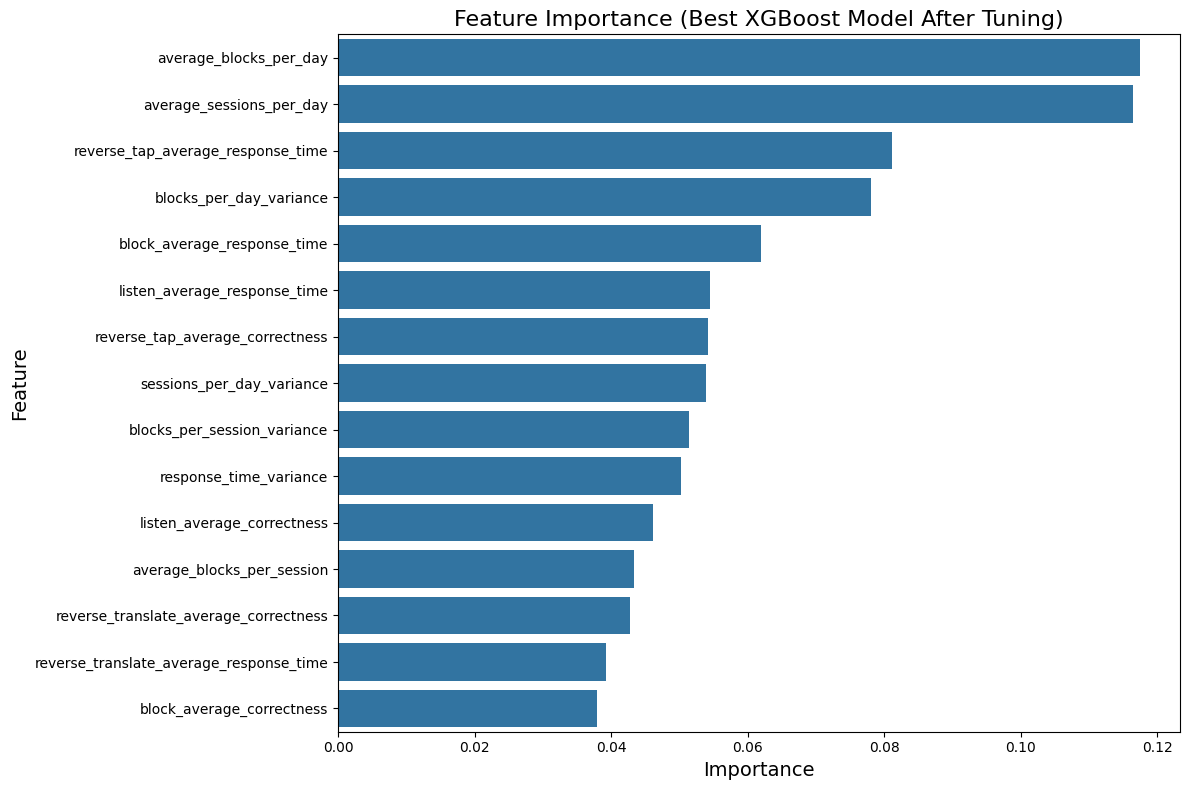

Top 15 most important features:
                                    Feature  Importance
10                   average_blocks_per_day    0.117480
11                 average_sessions_per_day    0.116512
5         reverse_tap_average_response_time    0.081199
14                  blocks_per_day_variance    0.078064
4               block_average_response_time    0.061976
7              listen_average_response_time    0.054511
1           reverse_tap_average_correctness    0.054174
15                sessions_per_day_variance    0.053868
13              blocks_per_session_variance    0.051466
16                   response_time_variance    0.050240
3                listen_average_correctness    0.046122
9                average_blocks_per_session    0.043352
2     reverse_translate_average_correctness    0.042741
6   reverse_translate_average_response_time    0.039313
0                 block_average_correctness    0.037959


In [19]:
# Feature Importance for the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Create visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance[:15])  # Show top 15 features
plt.title('Feature Importance (Best XGBoost Model After Tuning)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# Print top 15 features
print("Top 15 most important features:")
print(feature_importance.head(15))


Tuned XGBoost model accuracy: 0.4603

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.69      0.62      0.65        29
           1       0.37      0.43      0.40        23
           2       0.10      0.09      0.10        11

    accuracy                           0.46        63
   macro avg       0.39      0.38      0.38        63
weighted avg       0.47      0.46      0.46        63



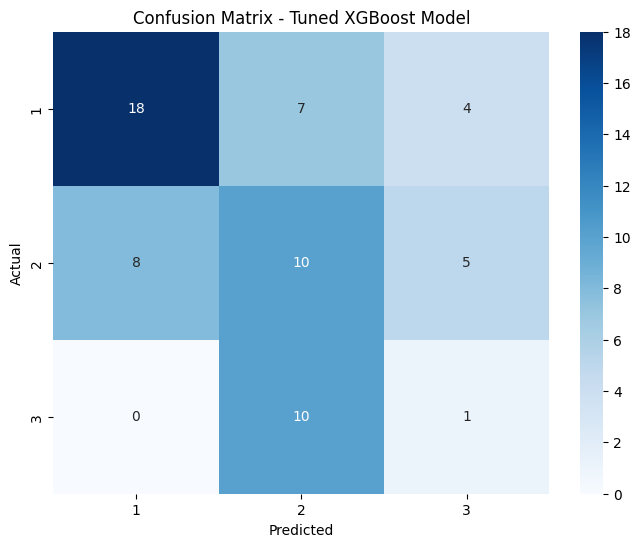

In [20]:
# Evaluate the tuned model
y_pred_tuned = best_xgb_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test_zero, y_pred_tuned)
print(f"\nTuned XGBoost model accuracy: {accuracy_tuned:.4f}")

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test_zero, y_pred_tuned))

# Confusion Matrix for tuned model
cm_tuned = confusion_matrix(y_test_zero, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['1', '2', '3'],
            yticklabels=['1', '2', '3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned XGBoost Model')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
n_classes = y_test_bin.shape[1]

# Get probability predictions
y_score = best_xgb_model.predict_proba(X_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))

# Add diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')

# Plot ROC curve for each class with different colors
colors = ['blue', 'red', 'green', 'purple']
class_names = ['Churn Category 1', 'Churn Category 2', 'Churn Category 3']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Add labels, title and other visual elements
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multiclass ROC Curve (XGBoost)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

In [ ]:
# Learning Curves
print("\nGenerating learning curves...")

# Use StratifiedKFold for CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Define train sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Use best XGBoost model from grid search
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X, y, 
    cv=cv,  
    n_jobs=-1, 
    train_sizes=train_sizes,
    scoring='accuracy'
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves for XGBoost (Multiclass Classification)')
plt.legend(loc='best')
plt.grid(True)
plt.ylim([0.4, 1.01])  # Set y-axis limits for better visualization
plt.show()